# SiT: Exploring Flow and Diffusion-based Generative Models with Scalable Interpolant Transformers

This notebook samples from pre-trained SiT models. SiTs are class-conSiTional latent interpolant models trained on ImageNet, unifying Flow and Diffusion Methods. 

[Paper]() | [GitHub](github.com/willisma/SiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the SiT GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
!git clone https://github.com/willisma/SiT.git
!pip install diffusers timm torchdiffeq --upgrade

正克隆到 'SiT'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 36 (delta 9), reused 31 (delta 9), pack-reused 1
接收对象中: 100% (36/36), 5.92 MiB | 3.63 MiB/s, 完成.
处理 delta 中: 100% (9/9), 完成.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# SiT imports:
import SiT, os
os.chdir('SiT')
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_XL_2
from PIL import Image
from IPython.display import display
from modelscope import snapshot_download
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

2024-02-21 15:41:46,732 - modelscope - INFO - PyTorch version 2.1.2+cu121 Found.
2024-02-21 15:41:46,735 - modelscope - INFO - TensorFlow version 2.14.0 Found.
2024-02-21 15:41:46,735 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2024-02-21 15:41:46,767 - modelscope - INFO - Loading done! Current index file version is 1.12.0, with md5 509123dba36c5e70a95f6780df348471 and a total number of 964 components indexed


# Download SiT-XL/2 Models

In [4]:
image_size = "256"
vae_model = snapshot_download("AI-ModelScope/sd-vae-ft-ema") #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
SiT_model = snapshot_download(f"AI-ModelScope/SiT-XL-2-{image_size}")
state_dict = find_model(f"{SiT_model}/SiT-XL-2-{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# 2. Sample from Pre-trained SiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

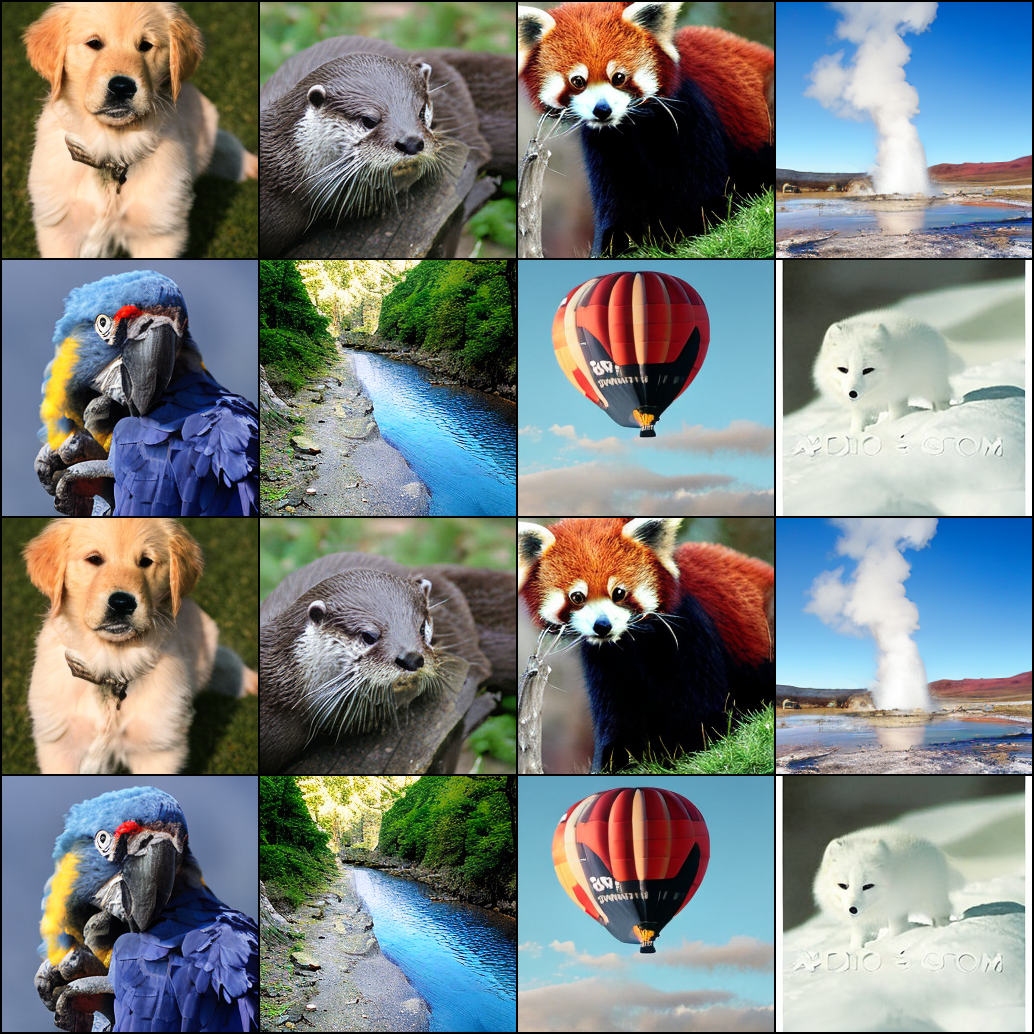

In [5]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
sampler_type = "ODE" #@param ["ODE", "SDE"]


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler" #@param ["Euler", "Heun"]
    diffusion_form = "linear" #@param ["constant", "SBDM", "sigma", "linear", "decreasing", "increasing-decreasing"]
    diffusion_norm = 1 #@param {type:"slider", min:0, max:10.0, step:0.1}
    last_step = "Mean" #@param ["Mean", "Tweedie", "Euler"]
    last_step_size = 0.4 #@param {type:"slider", min:0, max:1.0, step:0.01}
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    ) 
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" #@param ["dopri5", "euler", "rk4"]
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    ) 
samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)